<a href="https://colab.research.google.com/github/johnnfujita/tensorflow_certificate_prep/blob/main/dnn_for_timeseries_single_layer_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5


series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000



In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
l_0 = tf.keras.layers.Dense(1, input_shape = [window_size])
model = tf.keras.models.Sequential([l_0])

In [12]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)
print("Layer weights{}".format(l_0.get_weights()))

Layer weights[array([[-0.01473984],
       [ 0.01327908],
       [-0.06828497],
       [ 0.00587891],
       [ 0.07445447],
       [ 0.05329583],
       [-0.041001  ],
       [-0.05228669],
       [ 0.03431874],
       [-0.03805605],
       [ 0.04657792],
       [ 0.02166223],
       [-0.10423563],
       [ 0.04551996],
       [ 0.05036958],
       [ 0.05167388],
       [ 0.01066162],
       [ 0.19570109],
       [ 0.33641818],
       [ 0.36818174]], dtype=float32), array([0.01432567], dtype=float32)]


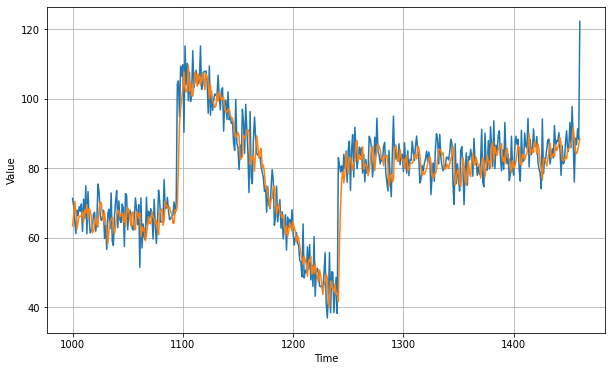

In [13]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid,results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9448385